# Visualización del Análisis de Dependencias Comerciales

Este notebook carga los resultados precalculados y genera:
- Tablas resumen (dependencias, relaciones críticas, intermediarios)
- Figuras listas para exportar
- Tablas en LaTeX
- Red interactiva con PyVis (opcional)

In [4]:
!jupyter nbconvert --to html "C:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\ejercicio_paper.ipynb"

[NbConvertApp] Converting notebook C:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\ejercicio_paper.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 3076896 bytes to C:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\ejercicio_paper.html


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import os
import gzip
from pathlib import Path

In [4]:
# 1. Carga de datos
current_dir = Path.cwd().parent.parent.parent
base_path = current_dir / "data" / "processed" / "ficheros_paper"

df_full = pd.read_csv(base_path / "dependencies_full.csv.gz", sep=";")
df_weighted = pd.read_csv(base_path / "weighted_dependencies.csv.gz", sep=";")
df_critical = pd.read_csv(base_path / "critical_relations.csv.gz", sep=";")
df_intermediary = pd.read_csv(base_path / "intermediary_roles.csv.gz", sep=";")
df_summary = pd.read_csv(base_path / "intermediary_summary.csv.gz", sep=";")

print("📊 Datos cargados correctamente")

📊 Datos cargados correctamente


In [ ]:
"C:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures"

WindowsPath('c:/Users/Usuario/Documents/Github/Seguridad económica/src/tables')

Figura guardada en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures\dependency_comparison.png
Tabla guardada en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\tables\concealment_table.csv y c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\tables\concealment_table.tex


,Importing Country,Exporting Country,Sector,Direct Dependency,Total Dependency,Concealment Ratio
5603299,HRV,USA,"Pulses and legumes, dried, preserved",0.005096,0.549105,107.743243
1499153,HRV,CHN,Dressing & dyeing of fur; processing of fur,0.005380,0.407688,75.778089
2731026,GRC,DNK,Live Swine,0.005535,0.386434,69.815660
1112798,NLD,HUN,Corn,0.005143,0.291550,56.685456
2731079,SVN,DNK,Live Swine,0.005058,0.281573,55.665375
1917293,IRL,ESP,Fishing,0.006477,0.352914,54.483163
5504210,EST,DEU,Publishing of newspapers journals etc.,0.005537,0.295052,53.282858
2731081,GRC,BEL,Live Swine,0.005535,0.279217,50.445197
2709474,BEL,CZE,Live Cattle,0.005404,0.250239,46.307021
160134,SVN,DEU,Animal feed ingredients and pet foods,0.007634,0.345778,45.296959


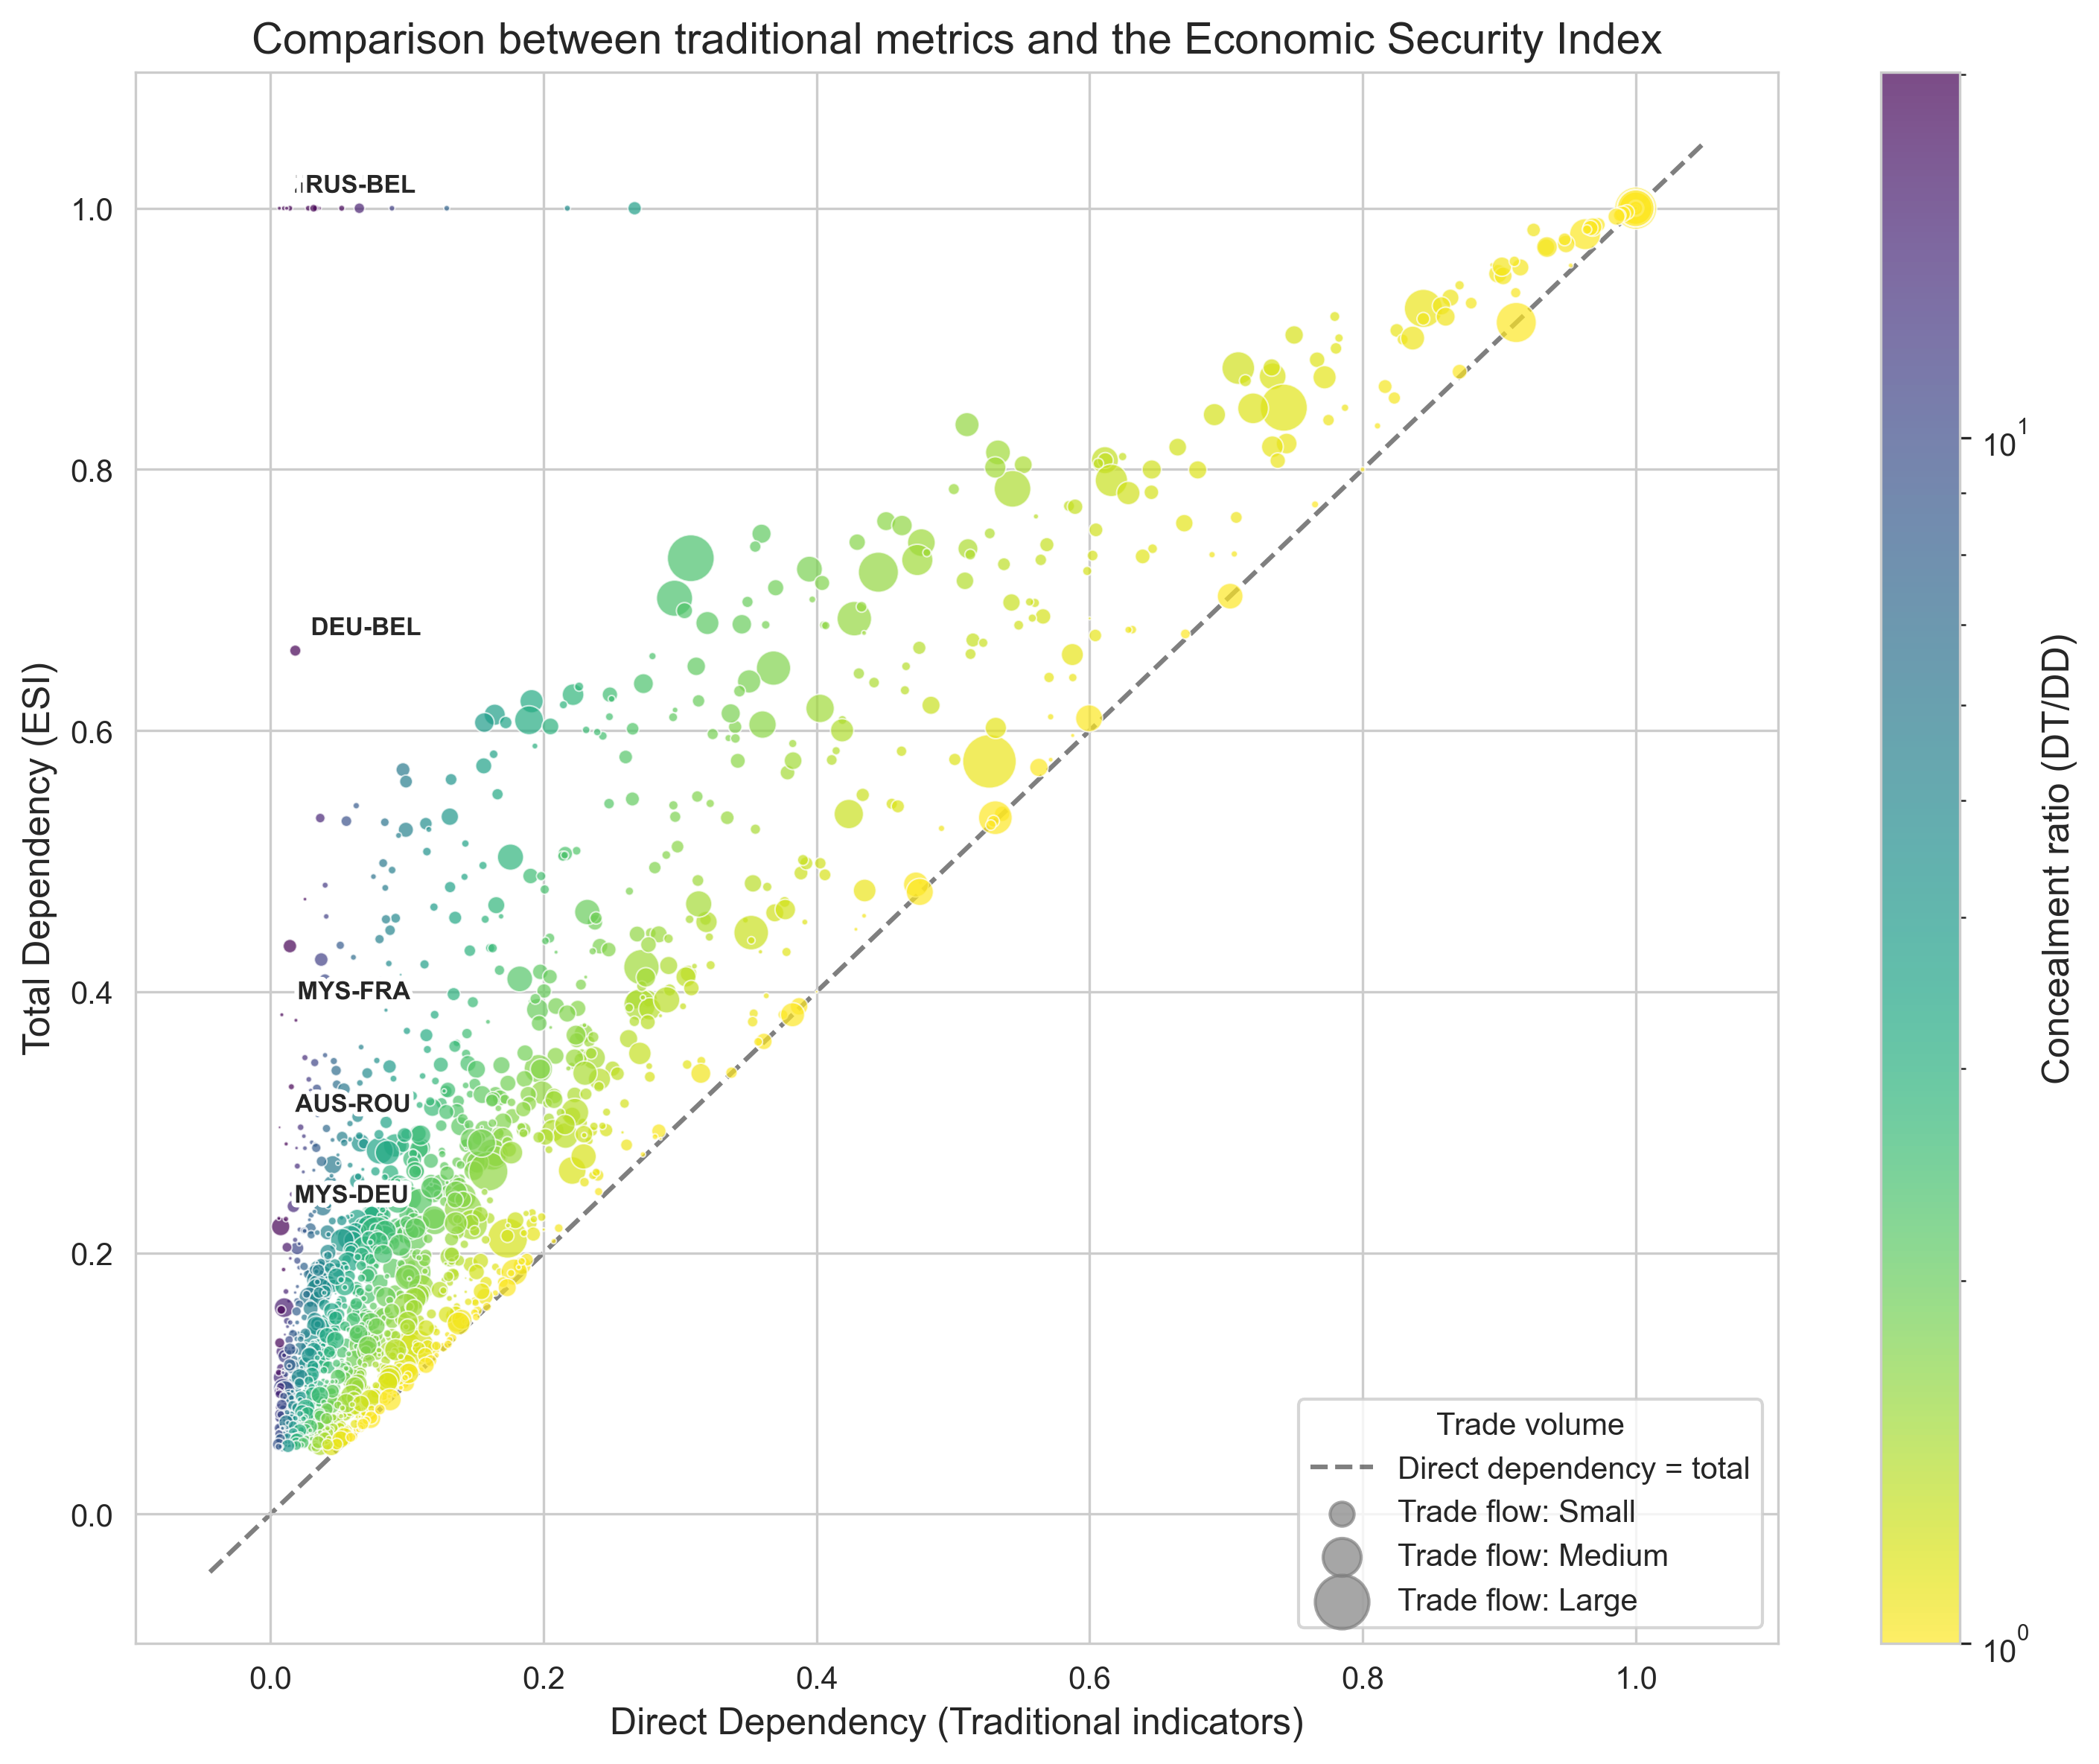

In [15]:
import matplotlib.colors
# Configuración para gráficos de alta calidad
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
sns.set_style("whitegrid")

base_path = current_dir / "notebooks" / "visualization" / "paper ISE"

output_path_fig = base_path / "figures"
output_path_tabs = base_path / "tables"

os.makedirs(output_path_fig, exist_ok=True)
os.makedirs(output_path_tabs, exist_ok=True)

# 1. Scatter plot: Dependencia Directa vs. Dependencia Total
def plot_dependency_comparison(df, n_sectors=5, output_path=output_path_fig):
    """
    Creates a scatter plot comparing direct vs. total dependency for the most relevant sectors.
    
    Args:
        df: DataFrame with dependency data
        n_sectors: Number of sectors to include
        output_path: Path to save the figure
    """
    # Seleccionar los sectores más relevantes (con mayor dependencia total promedio)
    top_sectors = (df.groupby('industry')['dependency_value']
                     .mean()
                     .sort_values(ascending=False)
                     .head(n_sectors)
                     .index.tolist())
    
    # Filtrar datos para esos sectores
    plot_data = df[df['industry'].isin(top_sectors)].copy()
    
    # Calcular ratio de ocultamiento
    plot_data['concealment_ratio'] = plot_data['dependency_value'] / plot_data['direct_dependency']
    plot_data['concealment_ratio'] = plot_data['concealment_ratio'].replace([np.inf, -np.inf], np.nan)
    plot_data = plot_data.dropna(subset=['concealment_ratio'])
    
    # Limitar a relaciones con dependencia total significativa (>0.05)
    plot_data = plot_data[plot_data['dependency_value'] > 0.05]
    
    # Normalizar tamaño para visualización
    plot_data['size'] = np.sqrt(plot_data['trade_value']) / np.sqrt(plot_data['trade_value'].max()) * 300
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # CAMBIO 2: Colormap con mejor contraste para visualizar el ratio de ocultamiento
    # Usar viridis que tiene mejor diferenciación visual o un mapa personalizado con más contraste
    cmap = plt.cm.viridis_r  # Alternativa: LinearSegmentedColormap.from_list('custom_cmap', ['#2c7bb6', '#ffde99', '#d7191c'])
    
    # Aplicar una transformación logarítmica al ratio para mejor visualización
    norm = matplotlib.colors.LogNorm(vmin=1, vmax=plot_data['concealment_ratio'].quantile(0.99))
    
    # Crear scatter plot
    scatter = ax.scatter(
        x=plot_data['direct_dependency'],
        y=plot_data['dependency_value'],
        s=plot_data['size'],
        c=plot_data['concealment_ratio'],
        cmap=cmap,
        norm=norm,  # Usar normalización logarítmica
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Línea diagonal de referencia (donde dependencia directa = total)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0, label="Direct dependency = total")
    
    # Añadir etiquetas para puntos con alta ratio de ocultamiento
    high_concealment = plot_data[plot_data['concealment_ratio'] > 2].sort_values('concealment_ratio', ascending=False).head(8)
    for _, row in high_concealment.iterrows():
        label = f"{row['dependent_country']}-{row['supplier_country']}"
        text = ax.annotate(
            label, 
            (row['direct_dependency'], row['dependency_value']),
            xytext=(5, 5), 
            textcoords='offset points',
            fontsize=8,
            weight='bold',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
        )
    
    # Añadir colorbar con escala logarítmica
    cbar = plt.colorbar(scatter)
    cbar.set_label('Concealment ratio (DT/DD)', fontsize=12)
    
    # CAMBIO 1: Etiquetas y título en inglés
    ax.set_xlabel('Direct Dependency (Traditional indicators)', fontsize=12)
    ax.set_ylabel('Total Dependency (ESI)', fontsize=12)
    ax.set_title('Comparison between traditional metrics and the Economic Security Index', fontsize=14)
    
    # Leyenda de tamaño
    sizes = [0.2, 0.5, 1.0]
    labels = ["Small", "Medium", "Large"]
    legend_sizes = [s * 300 for s in sizes]
    
    # Crear leyenda de tamaños
    for size, label in zip(legend_sizes, labels):
        ax.scatter([], [], c='gray', alpha=0.7, s=size, label=f'Trade flow: {label}')
    
    # CAMBIO 3: Mover leyenda a la parte inferior derecha
    ax.legend(loc='lower right', title="Trade volume")
    
    plt.tight_layout()
    plt.savefig(output_path / "dependency_comparison.png", dpi=300)
    print(f"Figura guardada en: {output_path / 'dependency_comparison.png'}")
    return fig

# 2. Tabla de "top 10" relaciones con mayor ratio de ocultamiento
def create_concealment_table(df, output_path=output_path_tabs):
    """
    Crea una tabla con las relaciones comerciales que tienen mayor ratio de ocultamiento,
    filtrando por países específicos de interés.
    
    Args:
        df: DataFrame con datos de dependencia
        output_path: Ruta donde guardar la tabla
    """
    # Calcular ratio de ocultamiento
    table_data = df.copy()
    table_data['concealment_ratio'] = table_data['dependency_value'] / table_data['direct_dependency']
    table_data['concealment_ratio'] = table_data['concealment_ratio'].replace([np.inf, -np.inf], np.nan)
    
    # Filtrar para dependencias significativas
    table_data = table_data[table_data['dependency_value'] > 0.1]
    
    # Lista de países de interés
    canada = ['CAN']
    usa = ['USA']
    china = ['CHN']
    eu_countries = [
        'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 
        'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 
        'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'
    ]
    
    countries_of_interest = canada + usa + china + eu_countries
    
    # Filtrar solo combinaciones entre los países de interés
    filtered_data = table_data[
        (table_data['dependent_country'].isin(countries_of_interest)) & 
        (table_data['supplier_country'].isin(countries_of_interest))
    ]
    
    # Seleccionar las top 10 con mayor ratio de ocultamiento entre los países filtrados
    top_concealed = filtered_data.sort_values('concealment_ratio', ascending=False).head(10)
    
    # Seleccionar y renombrar columnas para la tabla
    result_table = top_concealed[[
        'dependent_country', 'supplier_country', 'industry', 
        'direct_dependency', 'dependency_value', 'concealment_ratio'
    ]].copy()
    
    # Renombrar columnas para la tabla en inglés
    result_table.columns = [
        'Importing Country', 'Exporting Country', 'Sector',
        'Direct Dependency', 'Total Dependency', 'Concealment Ratio'
    ]
    
    # Guardar tabla - usar .csv como nombre de archivo en lugar de usar el directorio
    csv_path = output_path / "concealment_table.csv"
    latex_path = output_path / "concealment_table.tex"
    
    # Guardar tabla CSV
    result_table.to_csv(csv_path, index=False)
    
    # También crear versión LaTeX para el paper
    result_table.to_latex(latex_path, index=False, float_format="%.3f")
    
    print(f"Tabla guardada en: {csv_path} y {latex_path}")
    return result_table

plot_dependency_comparison(df_full)
create_concealment_table(df_full)

In [23]:

def plot_sectoral_heatmap_subplots(df, strategic_sectors, output_path):
    """
    Crea UNA figura con múltiples subplots (heatmaps), uno por cada sector estratégico.
    """
    # ... (tu código de preparación de datos hasta antes del bucle for) ...
    canada = ['CAN']
    usa = ['USA']
    china = ['CHN']
    eu_countries = [
        'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
        'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD',
        'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'
    ]
    countries_of_interest = canada + usa + china + eu_countries
    sector_data = df[
        (df['industry'].isin(strategic_sectors)) &
        (df['dependent_country'].isin(countries_of_interest)) &
        (df['supplier_country'].isin(countries_of_interest))
    ].copy()

    if 'trade_value' not in sector_data.columns:
        print("ADVERTENCIA: Columna 'trade_value' no encontrada. Usando media simple.")
        has_trade_value = False
    else:
        has_trade_value = True

    sector_data['region_importer'] = sector_data['dependent_country'].apply(
        lambda x: 'EU' if x in eu_countries else x
    )
    sector_data['region_exporter'] = sector_data['supplier_country'].apply(
        lambda x: 'EU' if x in eu_countries else x
    )
    main_regions = ['USA', 'CAN', 'CHN', 'EU']
    region_names = {'USA': 'United States', 'CAN': 'Canada', 'CHN': 'China', 'EU': 'European Union'} # Nombres completos para etiquetas

    # --- Modificación Principal ---
    num_sectors = len(strategic_sectors)
    # Ajusta las filas/columnas según necesites (ej. 3x3 para 9 sectores)
    n_cols = 3
    n_rows = int(np.ceil(num_sectors / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False) # Ajusta figsize
    axs = axs.flatten() # Facilita iterar sobre los ejes

    max_overall_dependency = 0 # Para una escala de color consistente si se desea

    pivot_tables = {} # Guardar pivots para calcular el máximo global si es necesario

    # Primero, calcular todos los pivots para determinar la escala de color global si se quiere
    for i, sector in enumerate(strategic_sectors):
        sector_slice = sector_data[sector_data['industry'] == sector].copy()

        if has_trade_value:
            dependency_by_region = sector_slice.groupby(['region_exporter', 'region_importer']).apply(
                lambda x: np.average(x['dependency_value'], weights=x['trade_value'])
                if x['trade_value'].sum() > 0 else x['dependency_value'].mean()
            ).reset_index(name='weighted_dependency')
            pivot = dependency_by_region.pivot_table(
                index='region_exporter', columns='region_importer', values='weighted_dependency'
            )
        else:
            pivot_data = sector_slice.groupby(['region_exporter', 'region_importer'])['dependency_value'].mean().reset_index()
            pivot = pivot_data.pivot_table(
                index='region_exporter', columns='region_importer', values='dependency_value'
            )

        for region in main_regions:
             if region not in pivot.index: pivot.loc[region] = 0
             if region not in pivot.columns: pivot[region] = 0
        pivot = pivot.reindex(main_regions).reindex(columns=main_regions).fillna(0)
        pivot_tables[sector] = pivot
        max_overall_dependency = max(max_overall_dependency, pivot.max().max())


    # Ahora, generar los heatmaps
    for i, sector in enumerate(strategic_sectors):
        ax = axs[i] # Selecciona el eje correcto
        pivot = pivot_tables[sector] # Recupera el pivot calculado

        # Usar max_overall_dependency para una escala de color consistente en todos los subplots
        # O comentar la línea de vmax para que cada subplot tenga su propia escala.
        current_vmax = min(1.0, max_overall_dependency * 1.1) # Escala consistente
        # current_vmax = min(1.0, pivot.max().max() * 1.2) # Escala individual (como en tu código original)


        sns.heatmap(
            pivot,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            vmin=0,
            vmax=current_vmax, # Usar el vmax calculado
            ax=ax, # ¡Importante: dibujar en el eje específico!
            cbar=False # Opcional: quitar barras de color individuales si usas una global
        )

        # Cambiar etiquetas a nombres completos
        ax.set_xticklabels([region_names.get(r, r) for r in main_regions])
        ax.set_yticklabels([region_names.get(r, r) for r in main_regions])

        weighting_method = "weighted by trade volume" if has_trade_value else "simple average"
        ax.set_title(f'{sector}\n({weighting_method})', fontsize=10) # Título más corto para subplot
        ax.set_xlabel('Importing Region', fontsize=9)
        ax.set_ylabel('Exporting Region', fontsize=9)

    # Ocultar ejes sobrantes si el número de sectores no llena la cuadrícula
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axs[j])

    # Añadir un título general a la figura
    fig.suptitle('Total Dependency Matrices by Strategic Sector', fontsize=16, y=1.02) # Ajusta 'y' si es necesario

    # Opcional: Añadir una única barra de color para toda la figura
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # Posición [left, bottom, width, height]
    # norm = plt.Normalize(vmin=0, vmax=current_vmax)
    # sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
    # sm.set_array([])
    # fig.colorbar(sm, cax=cbar_ax, label='Dependency Value')


    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Ajustar rect si se usa colorbar global
    # plt.tight_layout() # Si no se usa colorbar global

    # Guardar la figura COMPLETA
    output_filename = output_path / "heatmaps_subplots_all_sectors.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Figura con subplots guardada en: {output_filename}")

    plt.close(fig) # Cierra la figura para liberar memoria

    return True

def create_critical_dependencies_table(df, strategic_sectors=None, n_dependencies=20, output_path=output_path_tabs):
    """
    Crea una tabla con las relaciones comerciales con mayor dependencia total,
    filtrando por sectores estratégicos y países de interés.
    
    Args:
        df: DataFrame con datos de dependencia
        strategic_sectors: Lista de industrias estratégicas a incluir (opcional)
        n_dependencies: Número de dependencias críticas a mostrar
        output_path: Ruta donde guardar la tabla
    """
    # Lista de países de interés
    canada = ['CAN']
    usa = ['USA']
    china = ['CHN']
    eu_countries = [
        'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 
        'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 
        'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'
    ]
    
    countries_of_interest = canada + usa + china + eu_countries
    
    # Filtrar por países de interés
    table_data = df[
        (df['dependent_country'].isin(countries_of_interest)) &
        (df['supplier_country'].isin(countries_of_interest))
    ].copy()
    
    # Filtrar por sectores estratégicos si se especifican
    if strategic_sectors:
        table_data = table_data[table_data['industry'].isin(strategic_sectors)]
    
    # Filtrar relaciones significativas (dependencia total > 0.2)
    table_data = table_data[table_data['dependency_value'] > 0.2]
    
    # Calcular dependencia indirecta (si no existe ya)
    if 'indirect_dependency' not in table_data.columns:
        table_data['indirect_dependency'] = table_data['dependency_value'] - table_data['direct_dependency']
    
    # Seleccionar las top n con mayor dependencia total
    top_dependencies = table_data.sort_values('dependency_value', ascending=False).head(n_dependencies)
    
    # Seleccionar y renombrar columnas para la tabla
    result_table = top_dependencies[[
        'dependent_country', 'supplier_country', 'industry', 
        'direct_dependency', 'indirect_dependency', 'dependency_value'
    ]].copy()
    
    # Renombrar columnas para la tabla en inglés
    result_table.columns = [
        'Importing Country', 'Exporting Country', 'Sector',
        'Direct Dependency', 'Indirect Dependency', 'Total Dependency'
    ]
    
    # Guardar tabla
    csv_path = output_path / "critical_dependencies.csv"
    latex_path = output_path / "critical_dependencies.tex"
    
    # Guardar tabla CSV
    result_table.to_csv(csv_path, index=False)
    
    # También crear versión LaTeX para el paper
    result_table.to_latex(latex_path, index=False, float_format="%.3f")
    
    print(f"Tabla guardada en: {csv_path} y {latex_path}")
    return result_table

# Definir agrupaciones de sectores estratégicos
strategic_sector_groups = {
    'Metales básicos': ['Basic iron and steel', 'Basic precious and non-ferrous metals'],
    'Baterías': ['Accumulators primary cells and batteries'],
    'Electrónica': ['Electronic valves tubes etc.', 'TV and radio receivers and associated goods', 
                   'Office accounting and computing machinery'],
    'Alta tecnología': ['Aircraft and spacecraft', 'Medical surgical and orthopaedic equipment', 
                       'Optical instruments & photographic equipment']
}

# Aplanar la lista de sectores estratégicos
all_strategic_sectors = []
for sectors in strategic_sector_groups.values():
    all_strategic_sectors.extend(sectors)

# Crear mapas de calor y tabla de dependencias críticas
plot_sectoral_heatmap_subplots(df_full, all_strategic_sectors, Path(output_path_fig))
create_critical_dependencies_table(df_full, all_strategic_sectors, n_dependencies=20)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31216\2462045912.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dependency_by_region = sector_slice.groupby(['region_exporter', 'region_importer']).apply(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_31216\2462045912.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dependency_by_region = sector_slice.groupby(['region_exporter', 'region_importer']).app

Figura con subplots guardada en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures\heatmaps_subplots_all_sectors.png
Tabla guardada en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\tables\critical_dependencies.csv y c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\tables\critical_dependencies.tex


,Importing Country,Exporting Country,Sector,Direct Dependency,Indirect Dependency,Total Dependency
107230,EST,USA,Aircraft and spacecraft,0.832876,0.063123,0.895998
3573449,CAN,CHN,Office accounting and computing machinery,0.523846,0.339261,0.863107
107243,LVA,CAN,Aircraft and spacecraft,0.852869,0.007040,0.859909
107247,SWE,USA,Aircraft and spacecraft,0.674101,0.176896,0.850997
107251,POL,USA,Aircraft and spacecraft,0.685426,0.161041,0.846466
3573462,CZE,CHN,Office accounting and computing machinery,0.617852,0.220818,0.838670
107256,SVK,USA,Aircraft and spacecraft,0.596498,0.237273,0.833771
3573478,USA,CHN,Office accounting and computing machinery,0.470613,0.352778,0.823391
3573490,SVN,CHN,Office accounting and computing machinery,0.509551,0.298580,0.808131
3573494,POL,CHN,Office accounting and computing machinery,0.519092,0.284462,0.803555


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # Asegúrate de importar pandas
from pathlib import Path # Asegúrate de importar Path

# Asumiendo que df, strategic_sectors y output_path_fig están definidos
# output_path = Path(output_path_fig) # Asegúrate que output_path es un objeto Path

def plot_sectoral_heatmap_subplots(df, strategic_sectors, output_path):
    """
    Crea UNA figura con múltiples subplots (heatmaps), uno por cada sector estratégico.
    """
    # ... (tu código de preparación de datos hasta antes del bucle for) ...
    canada = ['CAN']
    usa = ['USA']
    china = ['CHN']
    eu_countries = [
        'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
        'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD',
        'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'
    ]
    countries_of_interest = canada + usa + china + eu_countries
    sector_data = df[
        (df['industry'].isin(strategic_sectors)) &
        (df['dependent_country'].isin(countries_of_interest)) &
        (df['supplier_country'].isin(countries_of_interest))
    ].copy()

    if 'trade_value' not in sector_data.columns:
        print("ADVERTENCIA: Columna 'trade_value' no encontrada. Usando media simple.")
        has_trade_value = False
    else:
        has_trade_value = True

    sector_data['region_importer'] = sector_data['dependent_country'].apply(
        lambda x: 'EU' if x in eu_countries else x
    )
    sector_data['region_exporter'] = sector_data['supplier_country'].apply(
        lambda x: 'EU' if x in eu_countries else x
    )
    main_regions = ['USA', 'CAN', 'CHN', 'EU']
    region_names = {'USA': 'United States', 'CAN': 'Canada', 'CHN': 'China', 'EU': 'European Union'} # Nombres completos para etiquetas

    # --- Modificación Principal ---
    num_sectors = len(strategic_sectors)
    # Ajusta las filas/columnas según necesites (ej. 3x3 para 9 sectores)
    n_cols = 3
    n_rows = int(np.ceil(num_sectors / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False) # Ajusta figsize
    axs = axs.flatten() # Facilita iterar sobre los ejes

    max_overall_dependency = 0 # Para una escala de color consistente si se desea

    pivot_tables = {} # Guardar pivots para calcular el máximo global si es necesario

    # Primero, calcular todos los pivots para determinar la escala de color global si se quiere
    for i, sector in enumerate(strategic_sectors):
        sector_slice = sector_data[sector_data['industry'] == sector].copy()

        if has_trade_value:
            dependency_by_region = sector_slice.groupby(['region_exporter', 'region_importer']).apply(
                lambda x: np.average(x['dependency_value'], weights=x['trade_value'])
                if x['trade_value'].sum() > 0 else x['dependency_value'].mean()
            ).reset_index(name='weighted_dependency')
            pivot = dependency_by_region.pivot_table(
                index='region_exporter', columns='region_importer', values='weighted_dependency'
            )
        else:
            pivot_data = sector_slice.groupby(['region_exporter', 'region_importer'])['dependency_value'].mean().reset_index()
            pivot = pivot_data.pivot_table(
                index='region_exporter', columns='region_importer', values='dependency_value'
            )

        for region in main_regions:
             if region not in pivot.index: pivot.loc[region] = 0
             if region not in pivot.columns: pivot[region] = 0
        pivot = pivot.reindex(main_regions).reindex(columns=main_regions).fillna(0)
        pivot_tables[sector] = pivot
        max_overall_dependency = max(max_overall_dependency, pivot.max().max())


    # Ahora, generar los heatmaps
    for i, sector in enumerate(strategic_sectors):
        ax = axs[i] # Selecciona el eje correcto
        pivot = pivot_tables[sector] # Recupera el pivot calculado

        # Usar max_overall_dependency para una escala de color consistente en todos los subplots
        # O comentar la línea de vmax para que cada subplot tenga su propia escala.
        current_vmax = min(1.0, max_overall_dependency * 1.1) # Escala consistente
        # current_vmax = min(1.0, pivot.max().max() * 1.2) # Escala individual (como en tu código original)


        sns.heatmap(
            pivot,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            vmin=0,
            vmax=current_vmax, # Usar el vmax calculado
            ax=ax, # ¡Importante: dibujar en el eje específico!
            cbar=False # Opcional: quitar barras de color individuales si usas una global
        )

        # Cambiar etiquetas a nombres completos
        ax.set_xticklabels([region_names.get(r, r) for r in main_regions])
        ax.set_yticklabels([region_names.get(r, r) for r in main_regions])

        weighting_method = "weighted by trade volume" if has_trade_value else "simple average"
        ax.set_title(f'{sector}\n({weighting_method})', fontsize=10) # Título más corto para subplot
        ax.set_xlabel('Importing Region', fontsize=9)
        ax.set_ylabel('Exporting Region', fontsize=9)

    # Ocultar ejes sobrantes si el número de sectores no llena la cuadrícula
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axs[j])

    # Añadir un título general a la figura
    fig.suptitle('Total Dependency Matrices by Strategic Sector', fontsize=16, y=1.02) # Ajusta 'y' si es necesario

    # Opcional: Añadir una única barra de color para toda la figura
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # Posición [left, bottom, width, height]
    # norm = plt.Normalize(vmin=0, vmax=current_vmax)
    # sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
    # sm.set_array([])
    # fig.colorbar(sm, cax=cbar_ax, label='Dependency Value')


    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Ajustar rect si se usa colorbar global
    # plt.tight_layout() # Si no se usa colorbar global

    # Guardar la figura COMPLETA
    output_filename = output_path / "heatmaps_subplots_all_sectors.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Figura con subplots guardada en: {output_filename}")

    plt.close(fig) # Cierra la figura para liberar memoria

    return True


plot_sectoral_heatmap_subplots(df_full, all_strategic_sectors, Path(output_path_fig))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31216\3369399380.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dependency_by_region = sector_slice.groupby(['region_exporter', 'region_importer']).apply(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_31216\3369399380.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dependency_by_region = sector_slice.groupby(['region_exporter', 'region_importer']).app

Figura con subplots guardada en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures\heatmaps_subplots_all_sectors.png


True

#Intermediarios críticos

In [25]:
current_dir

WindowsPath('c:/Users/Usuario/Documents/Github/Seguridad económica/src/notebooks/visualization/paper ISE')

In [29]:
current_dir 

WindowsPath('c:/Users/Usuario/Documents/Github/Seguridad económica/src/notebooks/visualization/paper ISE')

Gráfico de top intermediarios guardado en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures\top_intermediaries.png
Mapa de calor sectorial guardado en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures\intermediary_sectoral_heatmap.png


C:\Users\Usuario\AppData\Local\Temp\ipykernel_31216\3087629780.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Gráfico de influencia de intermediarios guardado en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\figures\intermediary_influence.png
Ranking sectorial guardado en: c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\tables\intermediary_ranking.csv y c:\Users\Usuario\Documents\Github\Seguridad económica\src\notebooks\visualization\paper ISE\tables\intermediary_ranking.tex


,Sector,Country,Frequency,Strength,Centrality Score
0,Accumulators primary cells and batteries,CHN,8294,93.028633,1.000000
1,Accumulators primary cells and batteries,DEU,3559,17.295318,0.283191
2,Accumulators primary cells and batteries,KOR,2528,24.766303,0.281653
3,Accumulators primary cells and batteries,USA,2908,20.782491,0.274285
4,Accumulators primary cells and batteries,JPN,1867,10.473125,0.157589
464,Aircraft and spacecraft,USA,3888,30.819121,1.000000
465,Aircraft and spacecraft,FRA,2397,19.479627,0.625843
466,Aircraft and spacecraft,GBR,2126,19.221458,0.592936
467,Aircraft and spacecraft,DEU,2123,16.109622,0.532045
468,Aircraft and spacecraft,CAN,1676,17.060486,0.504569


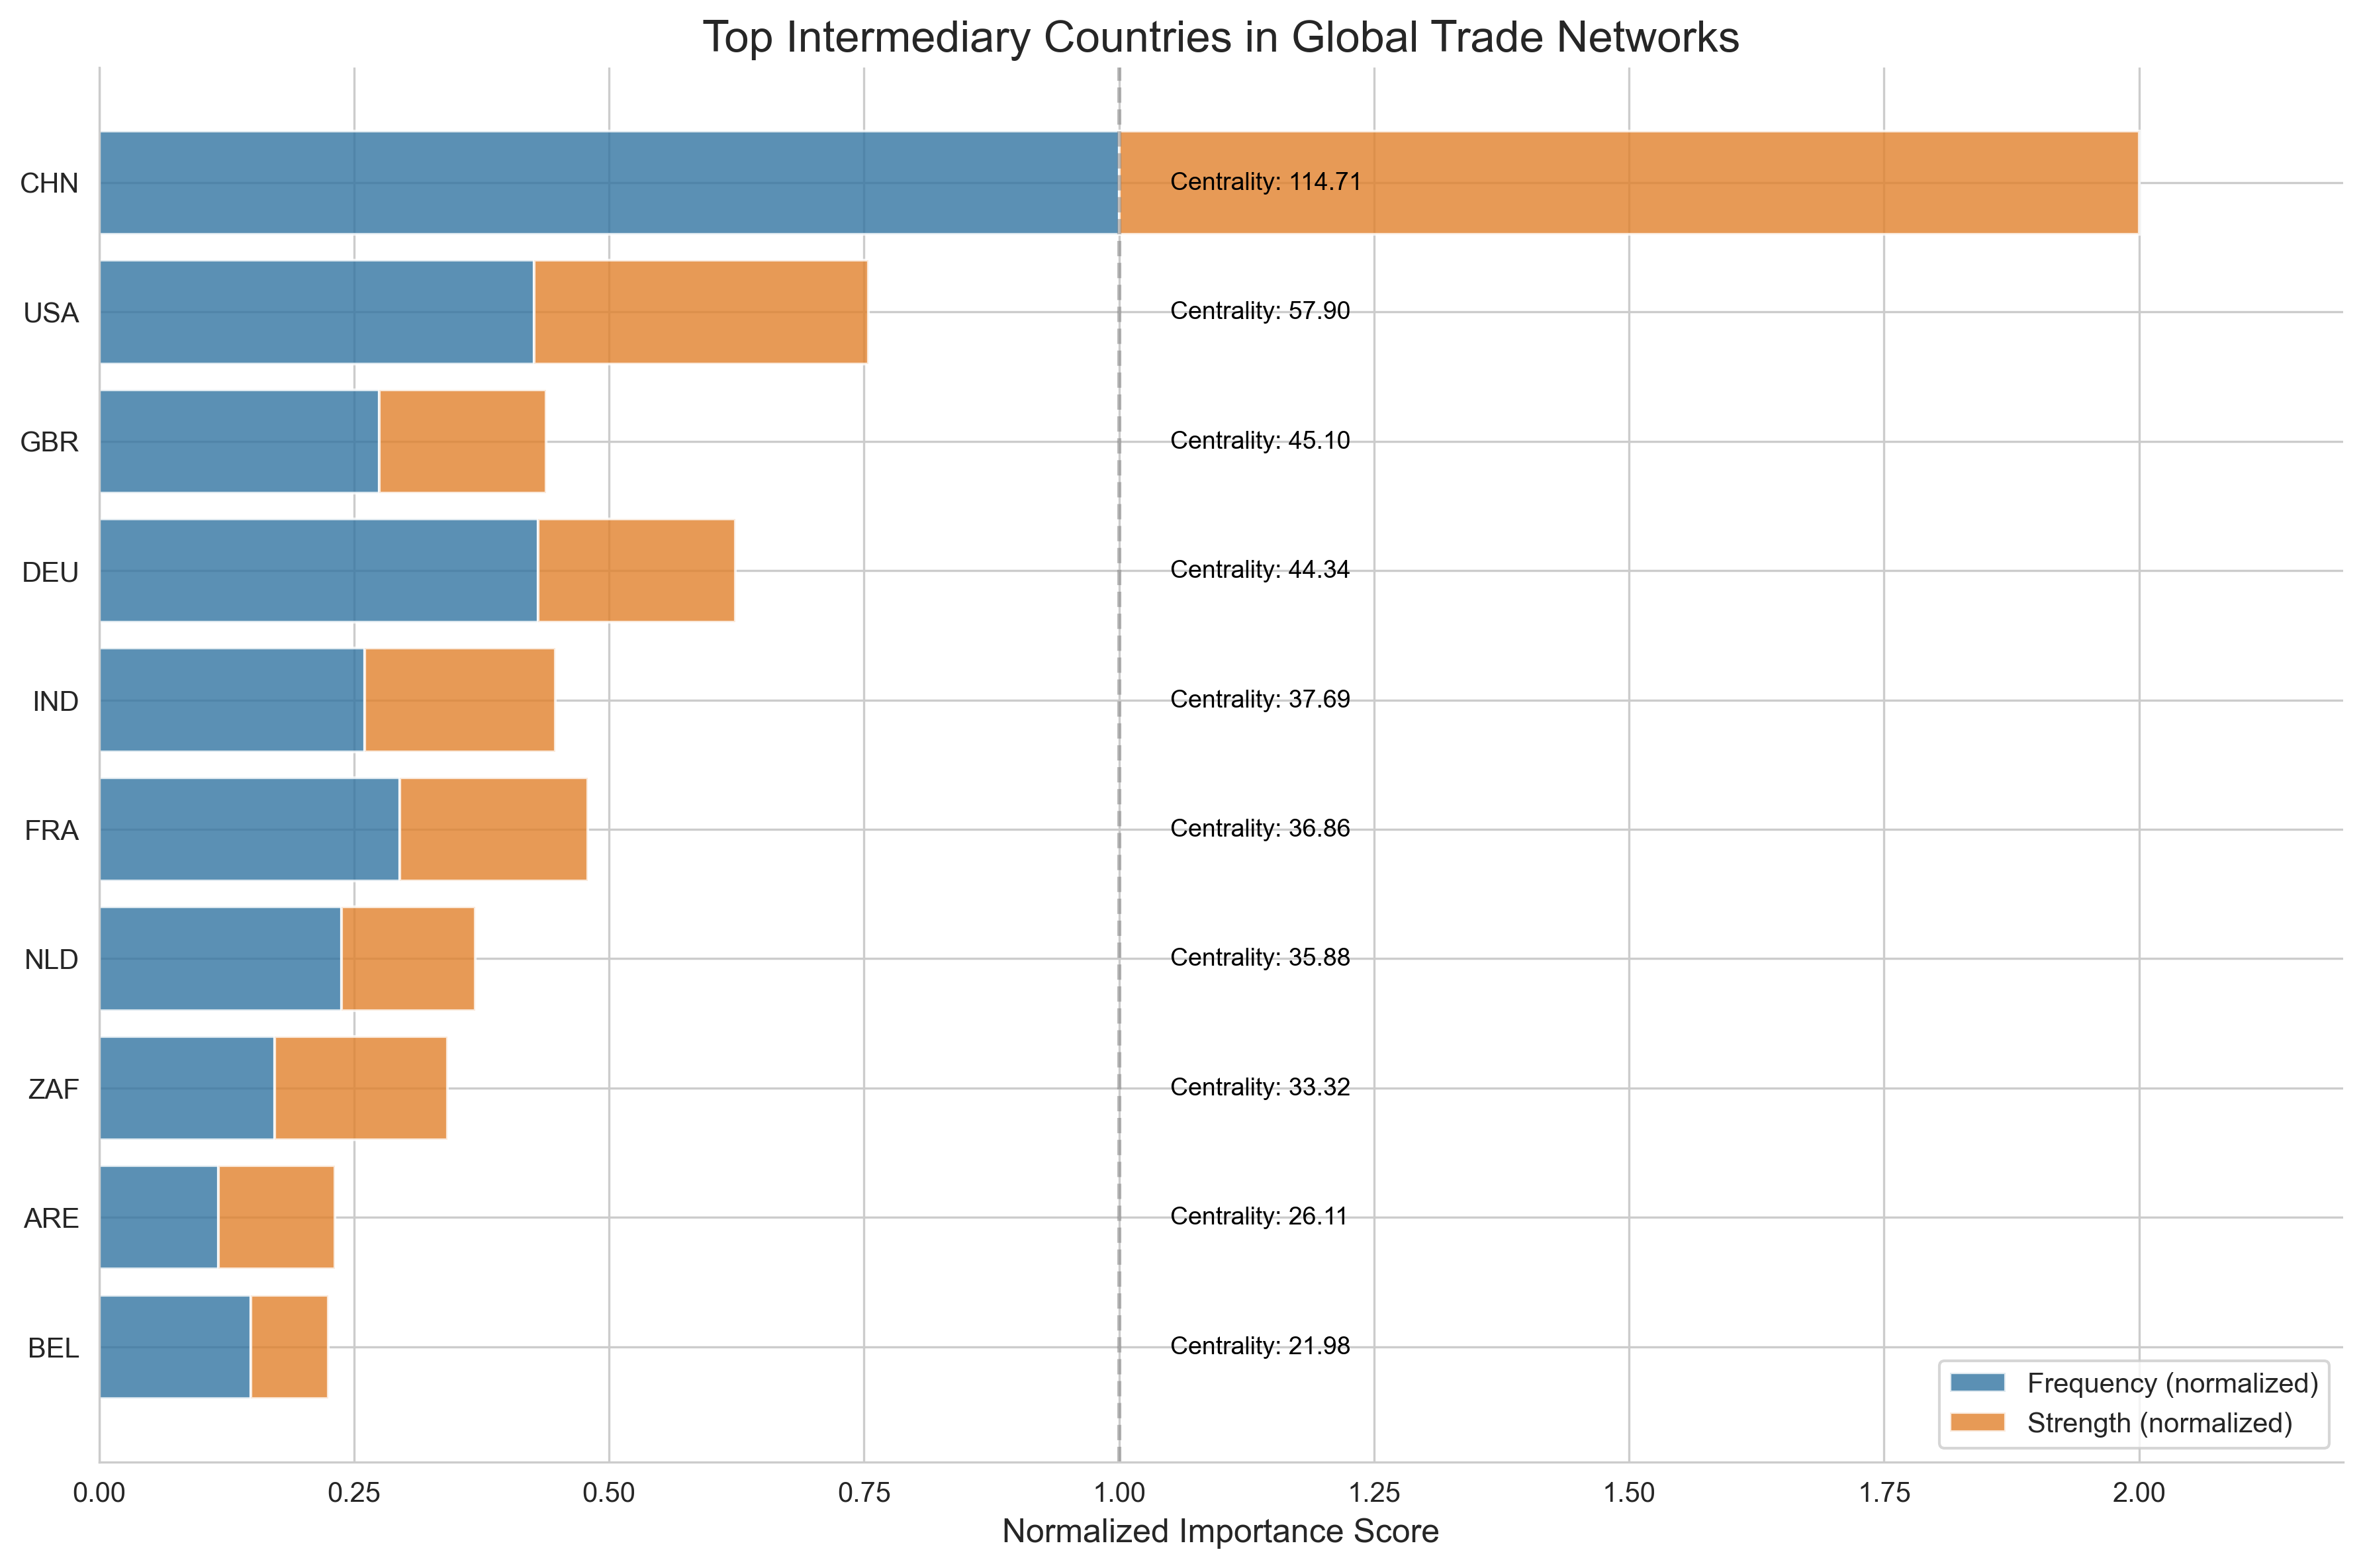

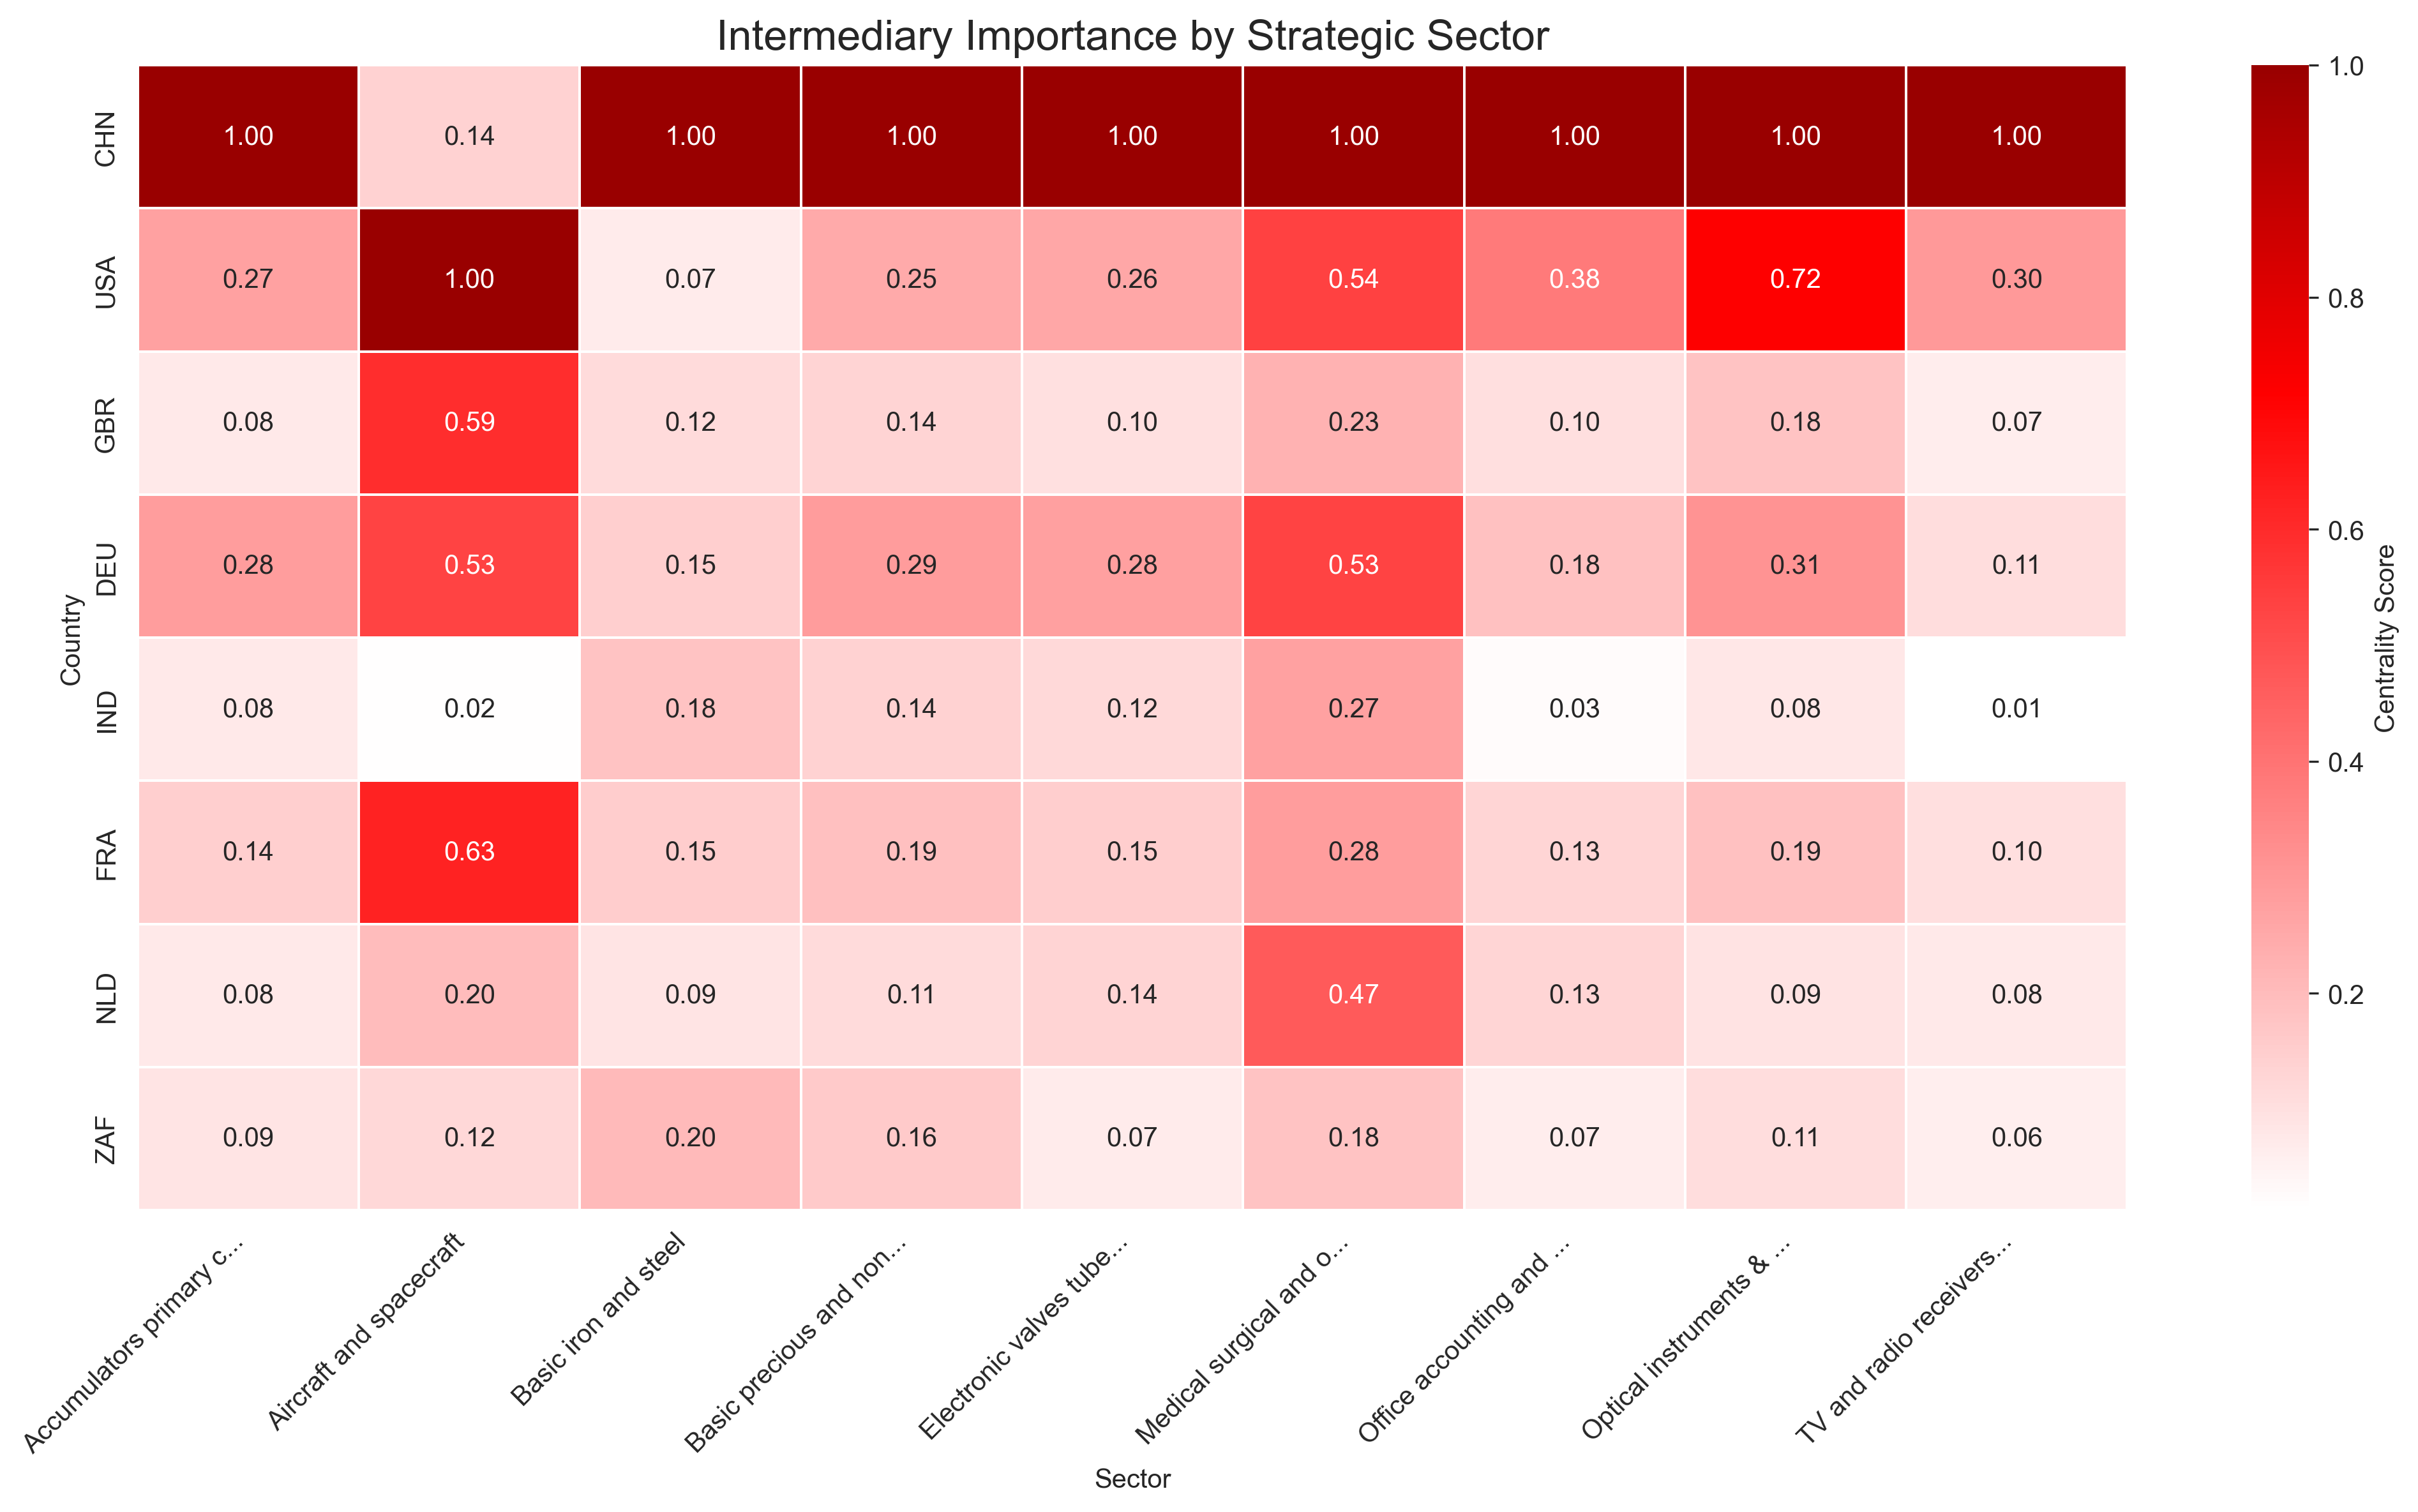

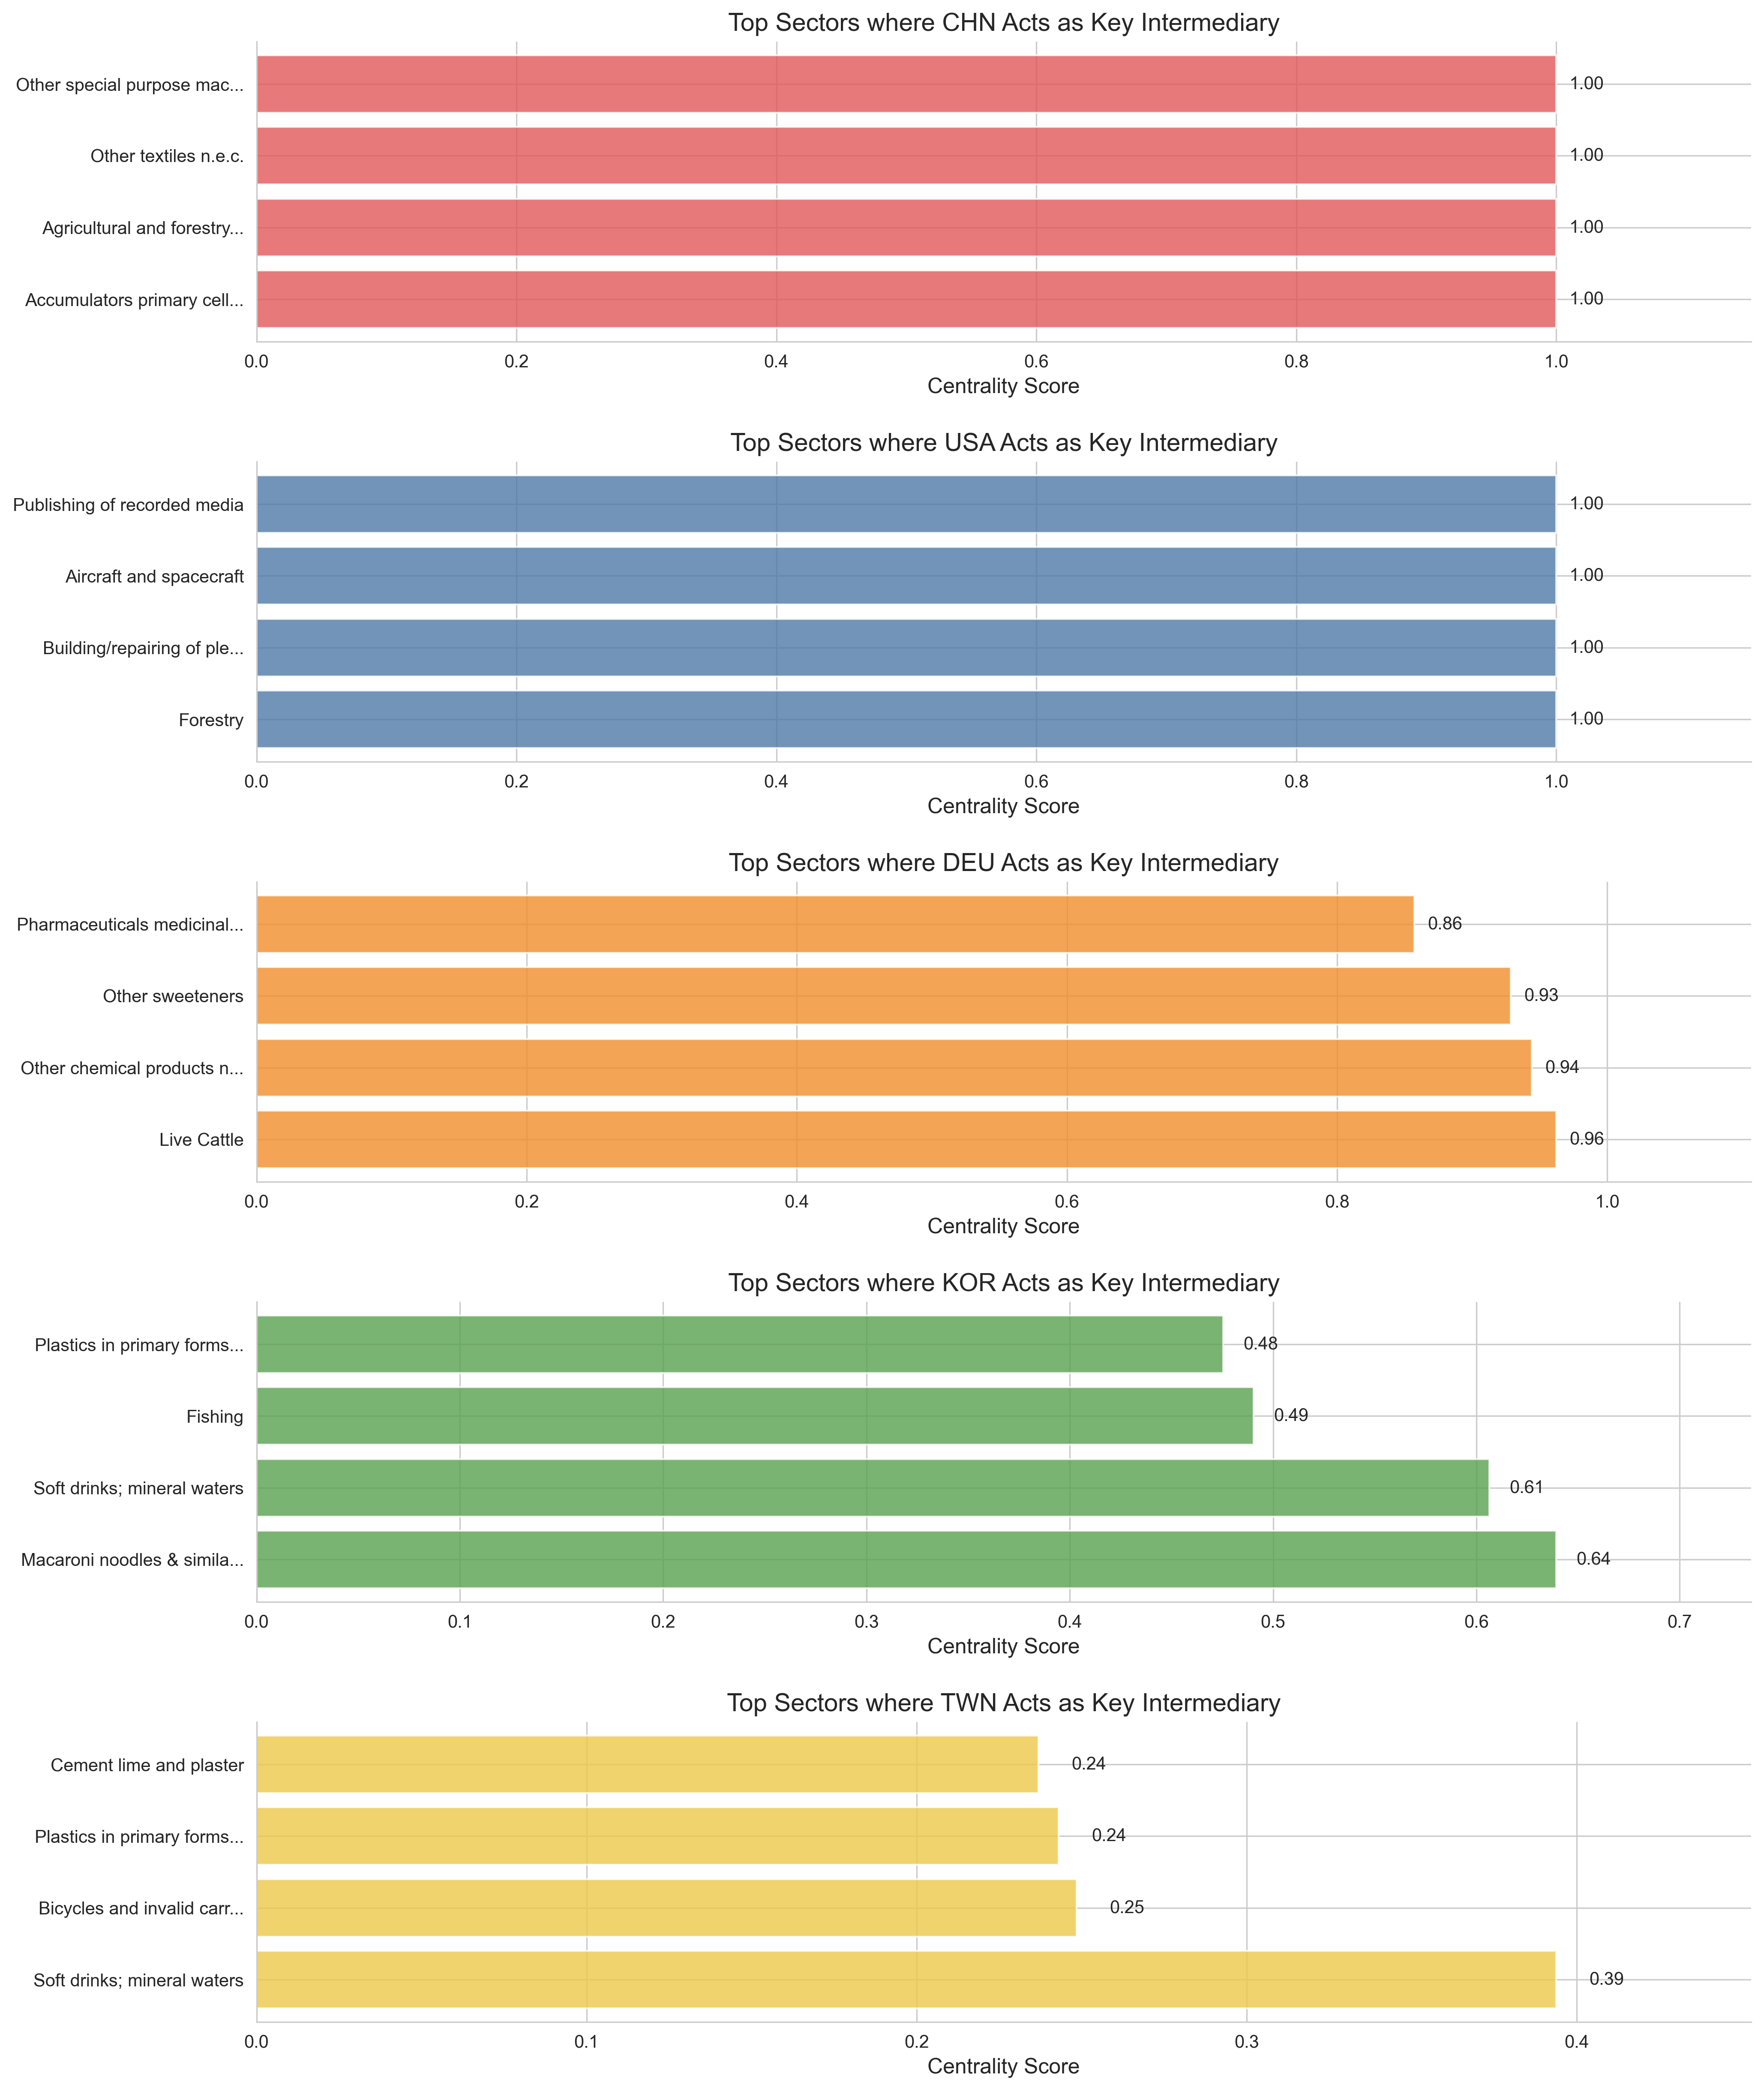

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

# Configuración para gráficos de alta calidad
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
sns.set_style("whitegrid")

# Definir rutas
current_dir = Path.cwd()
files_path =current_dir.parent.parent.parent / "data" / "processed" / "ficheros_paper"

base_path = current_dir / "notebooks" / "visualization" / "paper ISE"

output_path_fig = current_dir / "figures"
output_path_tabs = current_dir / "tables"

os.makedirs(output_path_fig, exist_ok=True)
os.makedirs(output_path_tabs, exist_ok=True)

# Carga de datos
intermediary_roles = pd.read_csv(files_path / "intermediary_roles.csv.gz", sep=";")
intermediary_summary = pd.read_csv(files_path / "intermediary_summary.csv.gz", sep=";")


# 1. Visualización mejorada de intermediarios clave
def plot_top_intermediaries(summary_df, top_n=10, output_path=output_path_fig):
    """
    Crea un gráfico de barras horizontal que muestra los intermediarios principales,
    con barras divididas mostrando frecuencia y fuerza.
    
    Args:
        summary_df: DataFrame con resumen de intermediarios
        top_n: Número de principales intermediarios a mostrar
        output_path: Ruta donde guardar la figura
    """
    # Seleccionar los top N intermediarios
    top_intermediaries = summary_df.sort_values('centrality_score', ascending=False).head(top_n).copy()
    
    # Normalizar los valores para que sean comparables visualmente
    max_freq = top_intermediaries['frequency'].max()
    max_strength = top_intermediaries['strength'].max()
    
    top_intermediaries['frequency_norm'] = top_intermediaries['frequency'] / max_freq
    top_intermediaries['strength_norm'] = top_intermediaries['strength'] / max_strength
    
    # Ordenar ascendentemente para que el gráfico muestre el más importante arriba
    top_intermediaries = top_intermediaries.sort_values('centrality_score')
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colores para las barras
    color_freq = '#3274A1'  # Azul
    color_strength = '#E1812C'  # Naranja
    
    # Barras para frecuencia
    bars1 = ax.barh(
        top_intermediaries['country'], 
        top_intermediaries['frequency_norm'],
        color=color_freq,
        alpha=0.8,
        label='Frequency (normalized)'
    )
    
    # Barras para fuerza (apiladas)
    bars2 = ax.barh(
        top_intermediaries['country'], 
        top_intermediaries['strength_norm'],
        left=top_intermediaries['frequency_norm'],
        color=color_strength,
        alpha=0.8,
        label='Strength (normalized)'
    )
    
    # Añadir valores de centralidad como texto
    for i, row in enumerate(top_intermediaries.itertuples()):
        ax.text(
            1.05,  # Posición después de las barras
            i,  # Posición vertical (índice)
            f"Centrality: {row.centrality_score:.2f}",
            va='center',
            fontsize=9,
            color='black'
        )
    
    # Etiquetas y título
    ax.set_xlabel('Normalized Importance Score', fontsize=12)
    ax.set_title('Top Intermediary Countries in Global Trade Networks', fontsize=16)
    
    # Leyenda
    ax.legend(loc='lower right')
    
    # Ajustar límites
    ax.set_xlim(0, 2.2)  # Dar espacio para los textos
    
    # Añadir una línea vertical en x=1 para separar visualmente
    ax.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
    
    # Mejora visual
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Guardar figura
    plt.savefig(output_path / "top_intermediaries.png")
    print(f"Gráfico de top intermediarios guardado en: {output_path / 'top_intermediaries.png'}")
    
    return fig

# 2. Mapa de calor sectorial de intermediarios
def plot_intermediary_heatmap(roles_df, sectors, countries=None, top_n=8, output_path=output_path_fig):
    """
    Crea un mapa de calor que muestra la importancia de los intermediarios por sector,
    con una escala de colores de blanco (0) a rojo intenso (1).
    
    Args:
        roles_df: DataFrame con roles de intermediarios
        sectors: Lista de sectores estratégicos a incluir
        countries: Lista de países a incluir (opcional, por defecto usa los top N)
        top_n: Si countries es None, número de intermediarios principales a mostrar
        output_path: Ruta donde guardar la figura
    """
    # Filtrar sectores de interés
    sector_data = roles_df[roles_df['industry'].isin(sectors)].copy()
    
    # Si no se especificaron países, usar los top N
    if countries is None:
        # Identificar los top N intermediarios globales
        top_countries = intermediary_summary.sort_values('centrality_score', ascending=False).head(top_n)['country'].tolist()
    else:
        top_countries = countries
    
    # Filtrar por países
    filtered_data = sector_data[sector_data['country'].isin(top_countries)]
    
    # Crear un pivot table para el mapa de calor
    pivot = filtered_data.pivot_table(
        index='country',
        columns='industry',
        values='centrality_score',
        fill_value=0
    )
    
    # Reordenar las filas y columnas
    pivot = pivot.reindex(index=top_countries)
    
    # Acortar nombres de sectores para mejor visualización
    shortened_sectors = {}
    for sector in sectors:
        if len(sector) > 25:
            shortened_sectors[sector] = sector[:22] + "..."
        else:
            shortened_sectors[sector] = sector
    
    pivot = pivot.rename(columns=shortened_sectors)
    
    # Crear figura
    plt.figure(figsize=(14, 8))
    
    # Crear colormap personalizado: blanco a rojo intenso
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(
        'white_to_red', 
        ['white', '#ffcccc', '#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000', '#990000'], 
        N=256
    )
    
    # Crear heatmap con el nuevo colormap
    heatmap = sns.heatmap(
        pivot, 
        cmap=custom_cmap,
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        cbar_kws={'label': 'Centrality Score'}
    )
    
    plt.title('Intermediary Importance by Strategic Sector', fontsize=16)
    plt.ylabel('Country')
    plt.xlabel('Sector')
    
    # Rotar etiquetas de las columnas para mejor lectura
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Guardar figura
    plt.savefig(output_path / "intermediary_sectoral_heatmap.png")
    print(f"Mapa de calor sectorial guardado en: {output_path / 'intermediary_sectoral_heatmap.png'}")
    
    return plt.gcf()

# 3. Visualización de dependencias por intermediarios específicos
def plot_intermediary_influence(roles_df, top_countries, top_n=3, output_path=output_path_fig):
    """
    Crea un gráfico que muestra la influencia de intermediarios clave en sectores específicos.
    
    Args:
        roles_df: DataFrame con roles de intermediarios
        top_countries: Lista de países intermediarios a analizar
        top_n: Número de sectores principales a mostrar por país
        output_path: Ruta donde guardar la figura
    """
    # Crear una figura con subplots para cada país
    n_countries = len(top_countries)
    fig = plt.figure(figsize=(15, 4 * n_countries))
    gs = GridSpec(n_countries, 1, figure=fig, hspace=0.4)
    
    country_colors = {
        'CHN': '#E15759',  # Rojo
        'USA': '#4E79A7',  # Azul
        'DEU': '#F28E2B',  # Naranja
        'JPN': '#76B7B2',  # Verde azulado
        'KOR': '#59A14F',  # Verde
        'TWN': '#EDC948',  # Amarillo
        'FRA': '#B07AA1',  # Púrpura
        'GBR': '#FF9DA7',  # Rosa
        'ITA': '#9C755F',  # Marrón
    }
    
    # Para cada país, crear un gráfico de barras con sus sectores top
    for i, country in enumerate(top_countries):
        # Filtrar datos para este país
        country_data = roles_df[roles_df['country'] == country].copy()
        
        # Si no hay datos, continuar con el siguiente
        if len(country_data) == 0:
            continue
        
        # Ordenar por centralidad y tomar los top N sectores
        top_sectors = country_data.sort_values('centrality_score', ascending=False).head(top_n)
        
        # Acortar nombres de sectores para mejor visualización
        top_sectors['short_industry'] = top_sectors['industry'].apply(
            lambda x: x[:25] + "..." if len(x) > 28 else x
        )
        
        # Crear subplot
        ax = fig.add_subplot(gs[i, 0])
        
        # Color para este país
        color = country_colors.get(country, '#636363')  # Gris por defecto
        
        # Crear barras horizontales
        bars = ax.barh(
            top_sectors['short_industry'],
            top_sectors['centrality_score'],
            color=color,
            alpha=0.8
        )
        
        # Añadir valores como texto
        for bar in bars:
            width = bar.get_width()
            ax.text(
                width + 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{width:.2f}',
                va='center',
                fontsize=10
            )
        
        # Título y etiquetas
        ax.set_title(f'Top Sectors where {country} Acts as Key Intermediary', fontsize=14)
        ax.set_xlabel('Centrality Score', fontsize=12)
        
        # Ajustar límites
        ax.set_xlim(0, top_sectors['centrality_score'].max() * 1.15)
        
        # Mejora visual
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Guardar figura
    plt.savefig(output_path / "intermediary_influence.png")
    print(f"Gráfico de influencia de intermediarios guardado en: {output_path / 'intermediary_influence.png'}")
    
    return fig

# Define los sectores estratégicos
strategic_sectors = [
    'Aircraft and spacecraft',
    'Accumulators primary cells and batteries',
    'Basic iron and steel',
    'Basic precious and non-ferrous metals',
    'Electronic valves tubes etc.',
    'TV and radio receivers and associated goods',
    'Office accounting and computing machinery',
    'Medical surgical and orthopaedic equipment',
    'Optical instruments & photographic equipment'
]

# Países clave para análisis detallado
key_countries = ['CHN', 'USA', 'DEU', 'KOR', 'TWN']

# Ejecutar análisis con las nuevas visualizaciones
plot_top_intermediaries(intermediary_summary, top_n=10)
plot_intermediary_heatmap(intermediary_roles, strategic_sectors)
plot_intermediary_influence(intermediary_roles, key_countries, top_n=4)

# Tabla para el paper (idéntica a la versión anterior)
def create_sectoral_intermediary_table(roles_df, strategic_sectors, output_path=output_path_tabs):
    """
    Crea una tabla con los principales intermediarios por sector estratégico.
    """
    # Lista para almacenar resultados
    all_rankings = []
    
    # Para cada sector, obtenemos los 5 intermediarios más importantes
    for sector in strategic_sectors:
        # Filtrar datos del sector
        sector_data = roles_df[roles_df['industry'] == sector].copy()
        
        # Si no hay datos para este sector, continuar con el siguiente
        if len(sector_data) == 0:
            print(f"No hay datos para el sector: {sector}")
            continue
        
        # Ordenar por puntuación de centralidad
        top5 = sector_data.sort_values('centrality_score', ascending=False).head(5)
        
        # Añadir columna con el sector
        top5['sector'] = sector
        
        # Añadir al resultado global
        all_rankings.append(top5)
    
    # Combinar resultados
    if all_rankings:
        result_table = pd.concat(all_rankings)
        
        # Seleccionar y renombrar columnas
        result_table = result_table[['sector', 'country', 'frequency', 'strength', 'centrality_score']]
        result_table.columns = ['Sector', 'Country', 'Frequency', 'Strength', 'Centrality Score']
        
        # Ordenar por sector y puntuación
        result_table = result_table.sort_values(['Sector', 'Centrality Score'], ascending=[True, False])
        
        # Guardar tabla
        csv_path = output_path / "intermediary_ranking.csv"
        latex_path = output_path / "intermediary_ranking.tex"
        
        result_table.to_csv(csv_path, index=False)
        result_table.to_latex(latex_path, index=False, float_format="%.3f")
        
        print(f"Ranking sectorial guardado en: {csv_path} y {latex_path}")
        return result_table
    else:
        print("No se encontraron datos para los sectores seleccionados.")
        return None

# Crear la tabla
create_sectoral_intermediary_table(intermediary_roles, strategic_sectors[:4])